In [1]:
import pandas as pd

df = pd.read_csv('../../input/clean_annual_wb_fred.csv')
df = df[df['year'] <= 2019]
df = df.rename(columns={"economy" : "isocode"})

df["date"] = pd.to_datetime(df["year"].astype(str) + "-01-01")
df.drop(columns="year", inplace=True)  # optional cleanup

# Selecting relevant columns
static_cols = ['isocode', 'date', '1DLGDP']
lag_cols = df.columns[df.columns.str.endswith('_L1') | df.columns.str.endswith('_L2')]
cols_to_include = static_cols + lag_cols.to_list()
df = df[cols_to_include].copy()
df = df.reset_index(drop=True)
df.drop(columns=['GDPGR_L1', '1DGDPGR_L2'], inplace=True)
print("Number of units: ", df["isocode"].nunique())
df

Number of units:  150


isocode       date    1DLGDP  1DLGDP_L1  1DLGDP_L2      LEND_L2  \
0        AFE 1980-01-01  5.318699   2.888342   1.476127 -1047.943026   
1        AFE 1981-01-01  3.934116   5.318699   2.888342  -696.596459   
2        AFE 1982-01-01  0.315334   3.934116   5.318699  -773.999721   
3        AFE 1983-01-01  0.039939   0.315334   3.934116 -1061.529652   
4        AFE 1984-01-01  3.310964   0.039939   0.315334 -1080.113180   
...      ...        ...       ...        ...        ...          ...   
5995     ZWE 2015-01-01  2.003446   1.473631   3.146699     9.740000   
5996     ZWE 2016-01-01  0.896921   2.003446   1.473631     9.467500   
5997     ZWE 2017-01-01  3.999218   0.896921   2.003446     8.541771   
5998     ZWE 2018-01-01  4.888413   3.999218   0.896921     7.113333   
5999     ZWE 2019-01-01 -6.541834   4.888413   3.999218     6.914167   

         RRATE_L2    1DDEBT_L2  2DLGOVCON_L1  2DLGFKF_L1  ...  FEDFUNDS_L2  \
0     3233.626846   942.444337     -0.238242   -2.852747  ...         7.94   
1     3302.639800  2367.068244      1.894273    5.105715  ...        11.20   
2     3305.102706  2064.786489     -1.640130    2.037248  ...        13.35   
3     3261.282561   894.782927      4.062284  -10.022484  ...        16.39   
4     3256.543016   803.989451     -2.333217   -8.376349  ...        12.24   
...           ...          ...           ...         ...  ...          ...   
5995     1.525435   -43.697495     49.351208   38.816294  ...         0.11   
5996     8.787605   -40.893438     -3.369751   -6.577338  ...         0.09   
5997     8.144427   -38.118247     -2.389474   -4.906594  ...         0.13   
5998     4.998563   -43.237287      1.207511    3.889627  ...         0.39   
5999   -64.281571   -49.127117    -37.375893   -0.598633  ...         1.00   

        WUI_L1    WUI_L2  1DUST10_L2  1DUSYIELD_L1  1DUSRRATE_L2  \
0     0.127085  0.049690        0.99      0.446788      0.790596   
1     0.062158  0.127085        1.02      2.251840      0.699691   
2     0.090546  0.062158        2.00      3.496616      1.173846   
3     0.092837  0.090546        2.49      0.737551      1.535289   
4     0.099054  0.092837       -0.91     -1.340747     -0.811175   
...        ...       ...         ...           ...           ...   
5995  0.147042  0.222608        0.55     -0.290000      0.301093   
5996  0.268378  0.147042        0.19      1.170000      0.324125   
5997  0.214639  0.268378       -0.40      0.430000     -0.022944   
5998  0.185867  0.214639       -0.30     -1.670000     -0.168375   
5999  0.192279  0.185867        0.49      0.660000      0.305207   

      1DFEDFUNDS_L2  1DLWTI_L2  2DLWTI_L1  1DWUI_L1  
0              2.40   3.802009  37.321956  0.077395  
1              3.26  41.123965  10.052287 -0.064928  
2              2.15  51.176252 -53.088738  0.028388  
3              3.04  -1.912486  -6.715538  0.002292  
4             -4.15  -8.628025  -1.503855  0.006217  
...             ...        ...        ...       ...  
5995          -0.03   3.888341  -8.782777 -0.075565  
5996          -0.02  -4.894436 -60.099289  0.121336  
5997           0.04 -64.993725  52.904802 -0.053739  
5998           0.26 -12.088924  28.589441 -0.028772  
5999           0.61  16.500517   7.887926  0.006412  

[6000 rows x 34 columns]

In [ ]:
isocode_list = ["ARG", "BEL", "BRA", "NGA", "FRA", "DEU", "ITA", "PER", "ESP", "USA",
                "BEN", "CHE", "COD", "DZA", "FIN", "GAB", "HND", "PHL", "SLV", "TUR"] 

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import pandas as pd
from OptimalPanel.optimizer import OptimalBundleRL

for isocode in isocode_list:
    
    # --- Configuration ---
    unit_col = 'isocode'
    time_col = 'date'
    target_col = '1DLGDP'
    target_unit = isocode
    feature_cols = df.columns.difference([unit_col, time_col, target_col])
    forecast_times = list(pd.date_range(start="2010-01-01", end="2019-01-01", freq="YS"))
    total_epochs = 800

    # --- Cutoff for similarity training ---
    train_cutoff = pd.to_datetime("2000-01-01")
    test_start = pd.to_datetime("2001-01-01")
    test_end = pd.to_datetime("2009-01-01")

    # --- Target test set ---
    target_test_df = df[(df[unit_col] == target_unit) & (df[time_col].between(test_start, test_end))]
    X_target_test = target_test_df[feature_cols]
    y_target_test = target_test_df[target_col]

    # --- Train models for each country and compute similarity ---
    country_rmse = {}

    for iso in df[unit_col].unique():
        train_df = df[(df[unit_col] == iso) & (df[time_col] <= train_cutoff)]
        if len(train_df) < 5 or len(X_target_test) == 0:
            continue
        
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]

        model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_target_test)
        rmse = sqrt(mean_squared_error(y_target_test, y_pred))
        country_rmse[iso] = rmse

    if len(country_rmse) < 5:
        print(f"⚠️ Skipping {target_unit} — insufficient valid donors")
        continue

    # --- Convert to similarity ---
    similarity_rmse_df = pd.DataFrame.from_dict(country_rmse, orient='index', columns=['RMSE'])
    similarity_rmse_df = similarity_rmse_df.sort_values(by='RMSE')

    donor_isos = similarity_rmse_df.index.drop(target_unit, errors='ignore').tolist()
    similarity_scores = 1 / (1 + similarity_rmse_df.loc[donor_isos, 'RMSE'].values)
    sim_tensor = torch.tensor(similarity_scores, dtype=torch.float32)

    print(f"\n🔍 Target: {target_unit} — Top donor scores:")
    for iso, score in zip(donor_isos[:10], similarity_scores[:10]):
        print(f"  {iso}: {score:.4f}")  

    # --- RL Optimization ---
    rl = OptimalBundleRL(
        df=df,
        unit_col=unit_col,
        time_col=time_col,
        target_col=target_col,
        feature_cols=feature_cols,
        target_unit=target_unit,
        donor_units=donor_isos,
        similarities=sim_tensor,
        forecast_times=forecast_times
    )

    rl.train(
        n_epochs=total_epochs,
        save=True,
        save_path=f"results/annual/results_{target_unit}.pkl"
    )


🔍 Target: ARG — Top donor scores:
  PNG: 0.1348
  CMR: 0.1288
  VUT: 0.1287
  BLZ: 0.1274
  ESP: 0.1264
  NZL: 0.1258
  KEN: 0.1250
  BRA: 0.1249
  SYC: 0.1249
  CAN: 0.1244
Epoch 0 — Avg MSE: 17.4251, Bundle Size: 73
Epoch 10 — Avg MSE: 17.6158, Bundle Size: 71
Epoch 20 — Avg MSE: 18.3896, Bundle Size: 70
Epoch 30 — Avg MSE: 20.9049, Bundle Size: 61
Epoch 40 — Avg MSE: 19.1434, Bundle Size: 68
Epoch 50 — Avg MSE: 18.2254, Bundle Size: 59
Epoch 60 — Avg MSE: 20.1434, Bundle Size: 66
Epoch 70 — Avg MSE: 17.7591, Bundle Size: 58
Epoch 80 — Avg MSE: 17.9088, Bundle Size: 65
Epoch 90 — Avg MSE: 16.0847, Bundle Size: 58
Epoch 100 — Avg MSE: 19.9289, Bundle Size: 62
Epoch 110 — Avg MSE: 17.6159, Bundle Size: 55
Epoch 120 — Avg MSE: 18.9038, Bundle Size: 62
Epoch 130 — Avg MSE: 19.4004, Bundle Size: 60
Epoch 140 — Avg MSE: 18.2437, Bundle Size: 61
Epoch 150 — Avg MSE: 19.1347, Bundle Size: 59
Epoch 160 — Avg MSE: 17.4184, Bundle Size: 58
Epoch 170 — Avg MSE: 19.6122, Bundle Size: 63
Epoch 18

## Interpretation

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_results_and_plot(results_dir="results/annual", top_n_donors=20, save=False, directory="results"):
    benchmark_data = []

    for filename in os.listdir(results_dir):
        if filename.endswith(".pkl") and filename.startswith("results_"):
            filepath = os.path.join(results_dir, filename)
            with open(filepath, "rb") as f:
                results = pickle.load(f)

            target_unit = results["target_unit"]
            print(f"📦 Loaded {filename}")

            # --- Plot learning curve ---
            plt.figure()
            plt.plot(results["avg_mse_per_epoch"], label="RL MSE")
            plt.xlabel("Epoch")
            plt.ylabel("MSE")
            plt.title(f"Learning Curve: {target_unit}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            if save:
                iso_path = f"{directory}/{target_unit}_learning_curve.pdf"
                plt.savefig(iso_path, format="pdf", bbox_inches="tight", dpi=300)
                print(f"✅ Plot saved to {iso_path}")
            plt.show()

            # --- Plot donor inclusion probabilities ---
            final_scores = {
                iso: probs[-1]
                for iso, probs in results["inclusion_probs_by_donor"].items()
                if len(probs) > 0
            }
            top_donors = sorted(final_scores.items(), key=lambda x: -x[1])[:top_n_donors]

            plt.figure()
            for iso, _ in top_donors:
                plt.plot(results["inclusion_probs_by_donor"][iso], label=iso)

            plt.xlabel("Epoch")
            plt.ylabel("Inclusion Probability")
            plt.title(f"Top {top_n_donors} Donor Inclusion Probs — {target_unit}")
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
            plt.grid(True)
            plt.tight_layout()
            if save:
                iso_path = f"{directory}/{target_unit}_donors_probabilities.pdf"
                plt.savefig(iso_path, format="pdf", bbox_inches="tight", dpi=300)
                print(f"✅ Plot saved to {iso_path}")
            plt.show()

            # --- Collect benchmark results ---
            benchmarks = results.get("benchmarks", {})
            if benchmarks:
                benchmark_data.append({
                    "country": target_unit,
                    "AR(1)": benchmarks.get("ar1_mse", None),
                    "Solo RF": benchmarks.get("solo_rf_mse", None),
                    "Full Panel RF": benchmarks.get("full_panel_rf_mse", None),
                    "Best Bundle RF": benchmarks.get("best_bundle_rf_mse", None),
                })

    return pd.DataFrame(benchmark_data)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_benchmark_summary(benchmark_df, save=False, save_path="benchmark_summary.pdf"):
    if benchmark_df.empty:
        print("No benchmark data to plot.")
        return

    # Normalize by AR(1) MSE for each country
    df_relative = benchmark_df.copy()
    for idx, row in df_relative.iterrows():
        ar1_mse = row["AR(1)"]
        if ar1_mse == 0:
            continue  # avoid division by zero
        for col in df_relative.columns:
            if col != "country":
                df_relative.at[idx, col] = row[col] / ar1_mse
        df_relative.at[idx, "AR(1)"] = 1.0  # set AR(1) to baseline

    # Melt for long format
    df_melted = df_relative.melt(id_vars="country", var_name="Method", value_name="Relative MSE")

    plt.figure(figsize=(14, 6))
    for method in df_melted["Method"].unique():
        subset = df_melted[df_melted["Method"] == method]
        plt.plot(subset["country"], subset["Relative MSE"], marker="o", label=method)

    plt.xticks(rotation=90)
    plt.ylabel("Relative MSE")
    plt.title("Benchmark Comparison Across Countries")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(save_path, format="pdf", bbox_inches="tight", dpi=300)
        print(f"✅ Plot saved to {save_path}")
    plt.show()

def plot_benchmark_boxplot(benchmark_df, save=False, save_path="benchmark_boxplot.pdf"):
    if benchmark_df.empty:
        print("No benchmark data to plot.")
        return

    # Normalize by AR(1) MSE for each country
    df_relative = benchmark_df.copy()
    for idx, row in df_relative.iterrows():
        ar1_mse = row["AR(1)"]
        if ar1_mse == 0:
            continue  # avoid division by zero
        for col in df_relative.columns:
            if col != "country":
                df_relative.at[idx, col] = row[col] / ar1_mse
        df_relative.at[idx, "AR(1)"] = 1.0  # set AR(1) to baseline

    # Melt for long format
    df_melted = df_relative.melt(id_vars="country", var_name="Method", value_name="Relative MSE")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="Method", y="Relative MSE", palette="Set2")
    plt.ylabel("Relative MSE")
    plt.title("Distribution of Relative MSE by Method")
    plt.grid(True, axis='y')

    if save:
        plt.savefig(save_path, format="pdf", bbox_inches="tight", dpi=300)
        print(f"✅ Boxplot saved to {save_path}")
    plt.show()

📦 Loaded results_FIN.pkl
✅ Plot saved to results/annual/figures/FIN_learning_curve.pdf


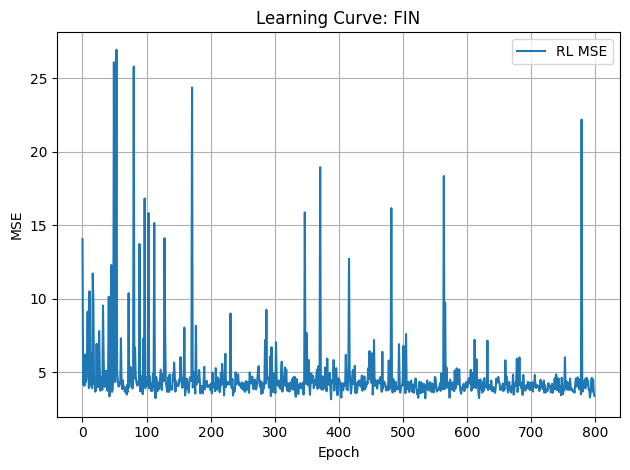

✅ Plot saved to results/annual/figures/FIN_donors_probabilities.pdf


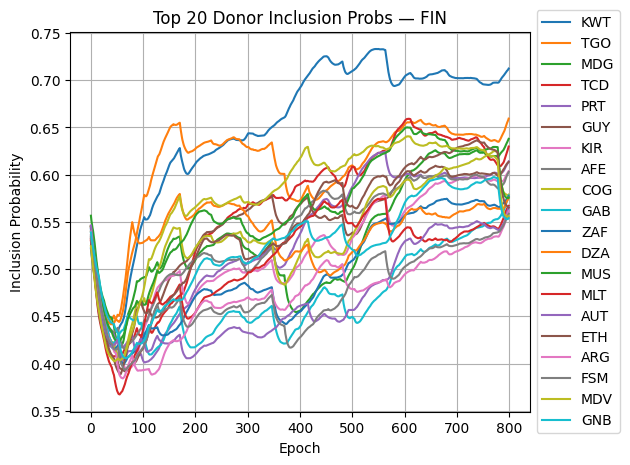

📦 Loaded results_BRA.pkl
✅ Plot saved to results/annual/figures/BRA_learning_curve.pdf


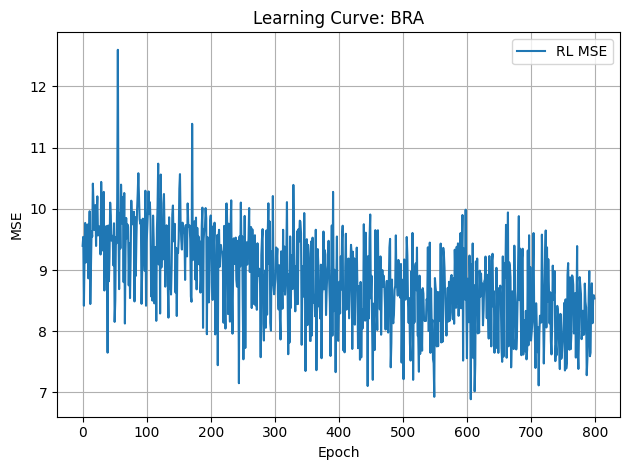

✅ Plot saved to results/annual/figures/BRA_donors_probabilities.pdf


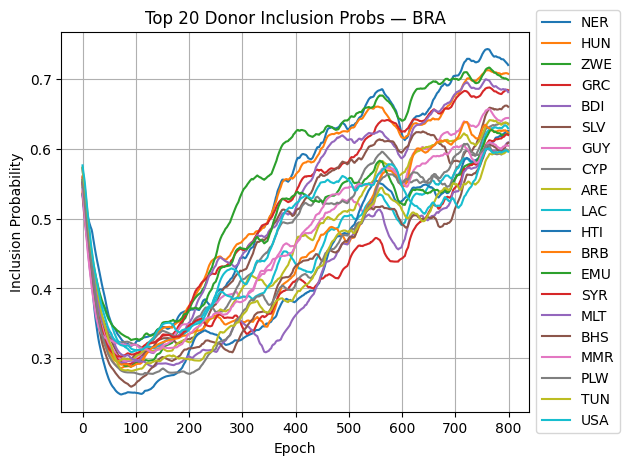

📦 Loaded results_BEN.pkl
✅ Plot saved to results/annual/figures/BEN_learning_curve.pdf


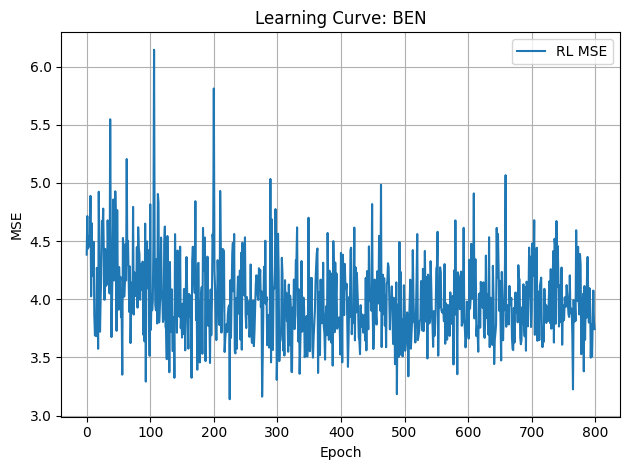

✅ Plot saved to results/annual/figures/BEN_donors_probabilities.pdf


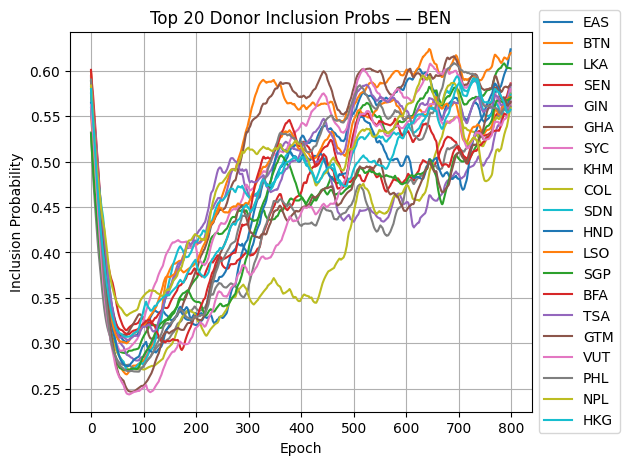

📦 Loaded results_GAB.pkl
✅ Plot saved to results/annual/figures/GAB_learning_curve.pdf


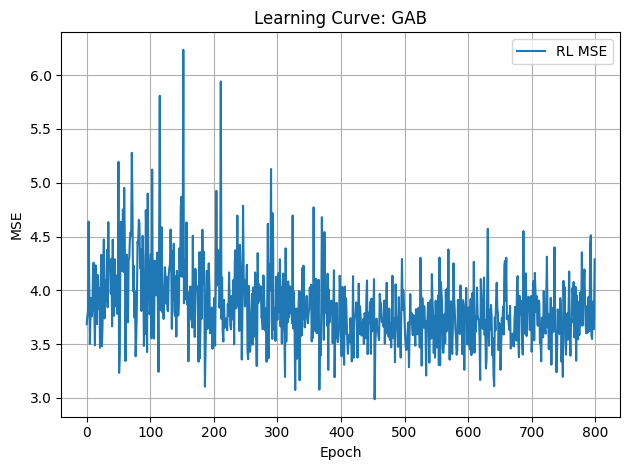

✅ Plot saved to results/annual/figures/GAB_donors_probabilities.pdf


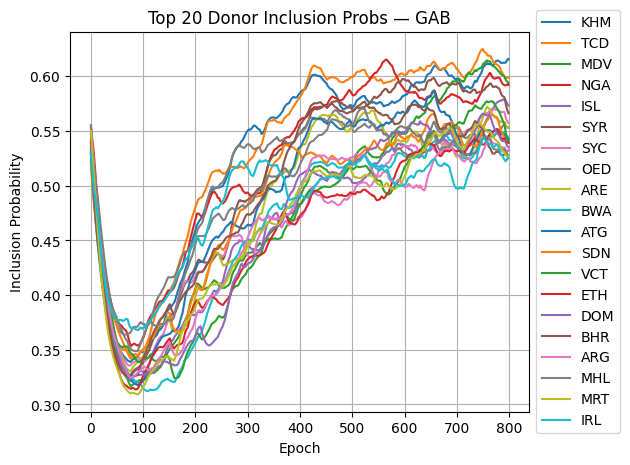

📦 Loaded results_FRA.pkl
✅ Plot saved to results/annual/figures/FRA_learning_curve.pdf


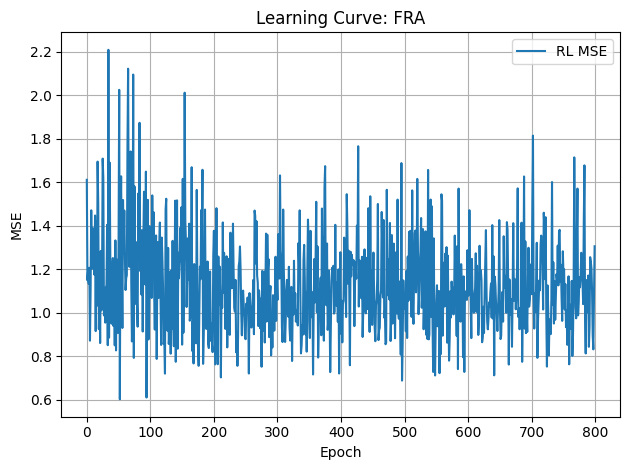

✅ Plot saved to results/annual/figures/FRA_donors_probabilities.pdf


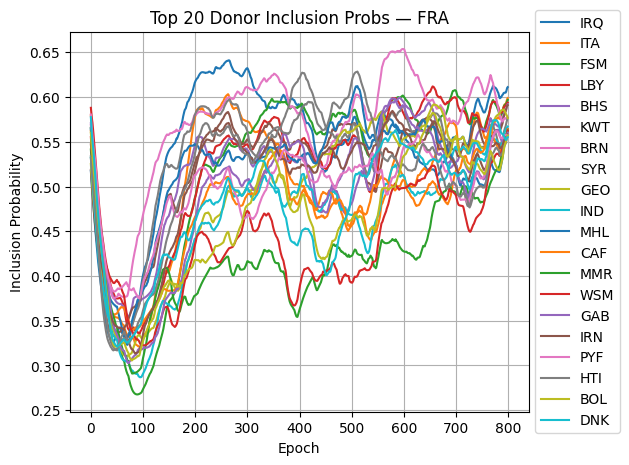

📦 Loaded results_BEL.pkl
✅ Plot saved to results/annual/figures/BEL_learning_curve.pdf


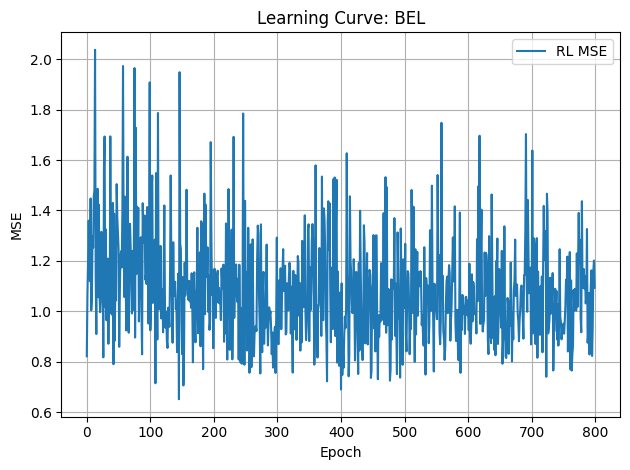

✅ Plot saved to results/annual/figures/BEL_donors_probabilities.pdf


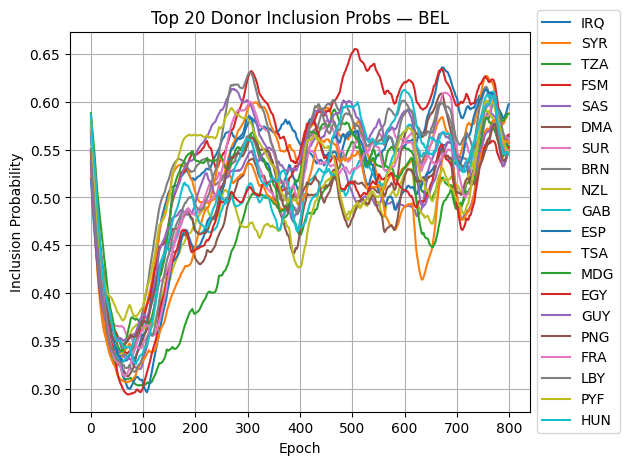

📦 Loaded results_HND.pkl
✅ Plot saved to results/annual/figures/HND_learning_curve.pdf


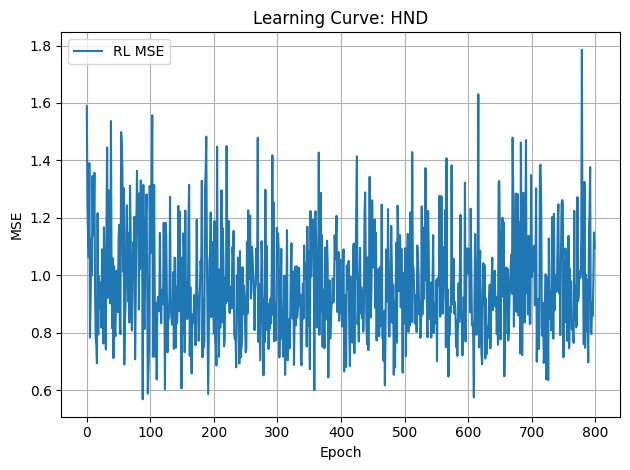

✅ Plot saved to results/annual/figures/HND_donors_probabilities.pdf


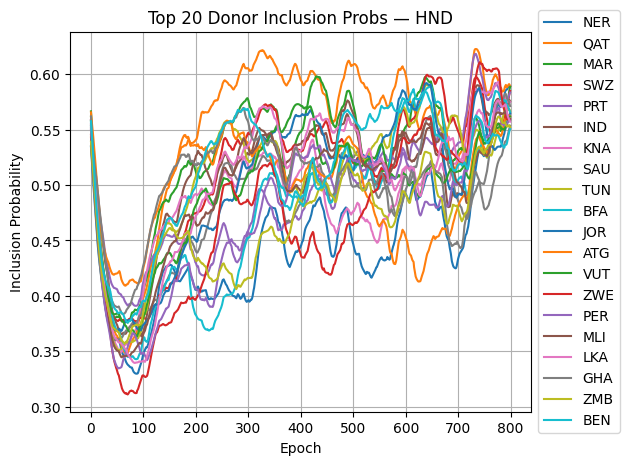

📦 Loaded results_ARG.pkl
✅ Plot saved to results/annual/figures/ARG_learning_curve.pdf


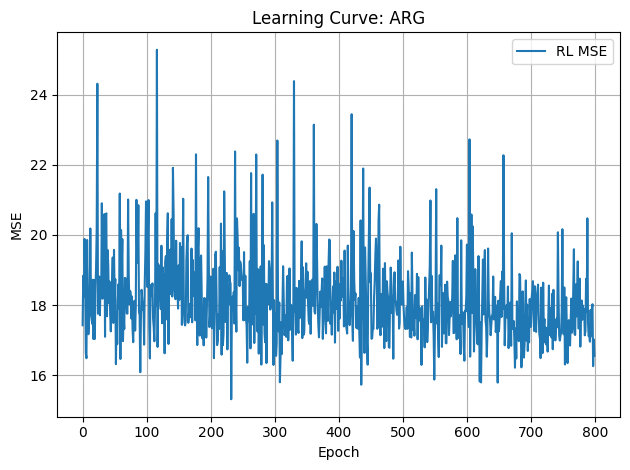

✅ Plot saved to results/annual/figures/ARG_donors_probabilities.pdf


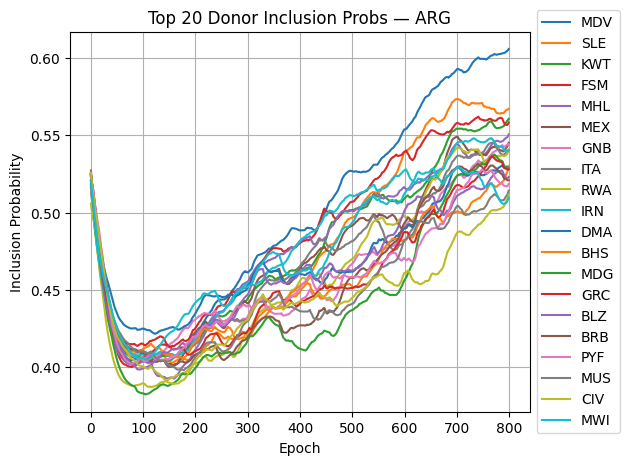

📦 Loaded results_PER.pkl
✅ Plot saved to results/annual/figures/PER_learning_curve.pdf


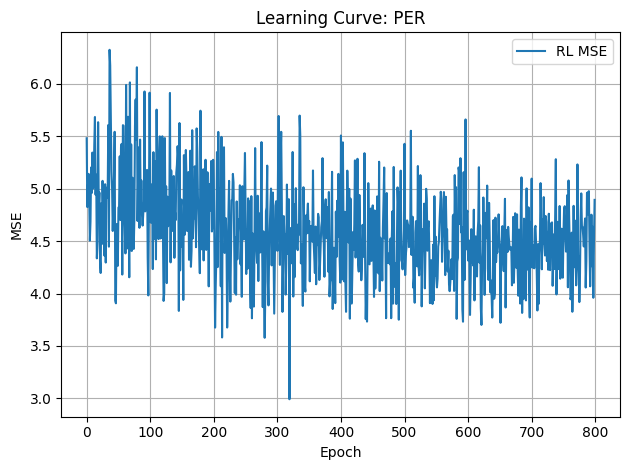

✅ Plot saved to results/annual/figures/PER_donors_probabilities.pdf


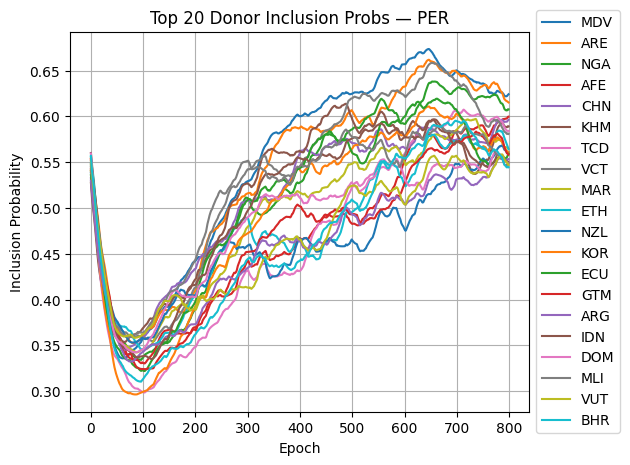

📦 Loaded results_ESP.pkl
✅ Plot saved to results/annual/figures/ESP_learning_curve.pdf


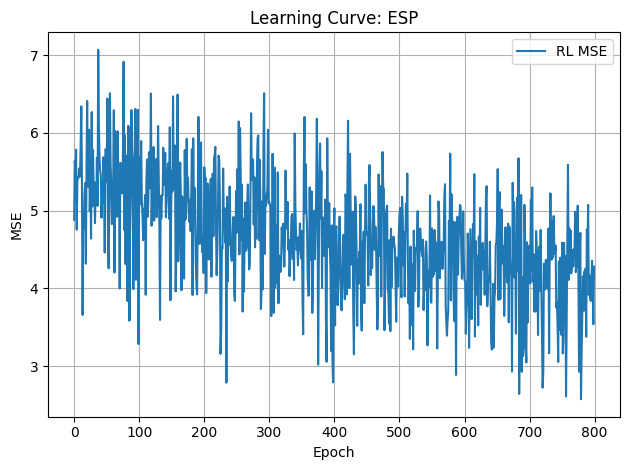

✅ Plot saved to results/annual/figures/ESP_donors_probabilities.pdf


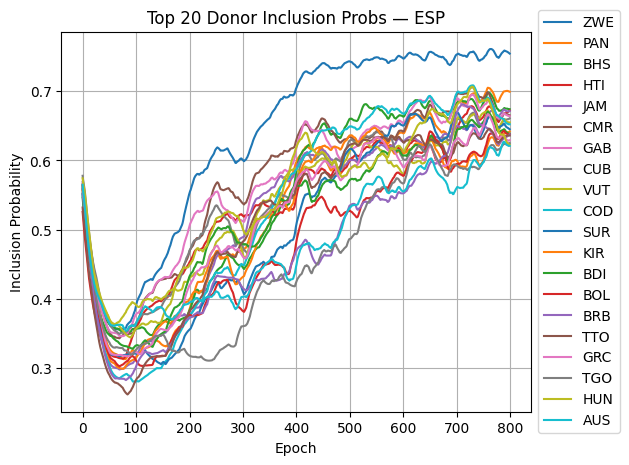

📦 Loaded results_PHL.pkl
✅ Plot saved to results/annual/figures/PHL_learning_curve.pdf


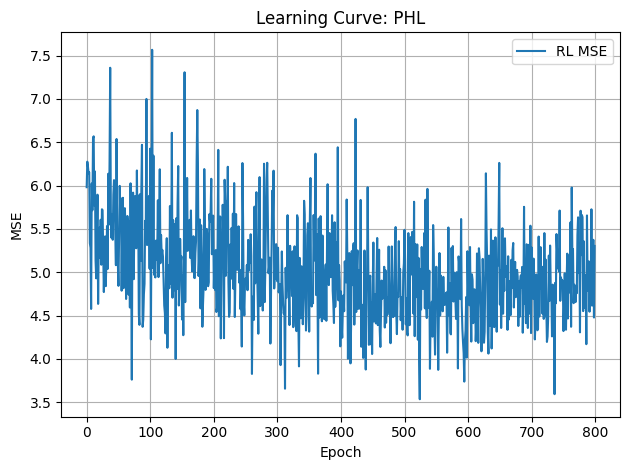

✅ Plot saved to results/annual/figures/PHL_donors_probabilities.pdf


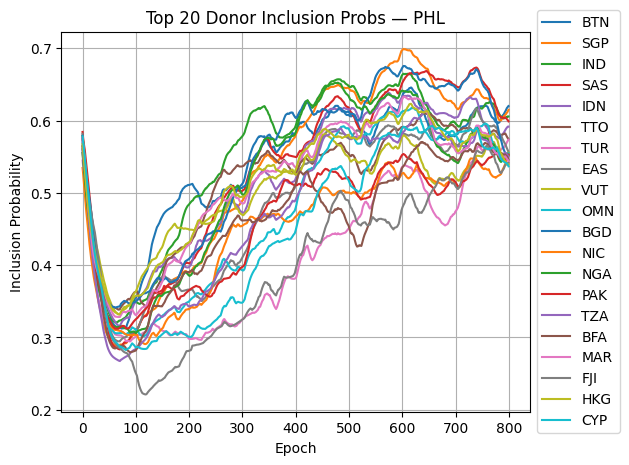

📦 Loaded results_CHE.pkl
✅ Plot saved to results/annual/figures/CHE_learning_curve.pdf


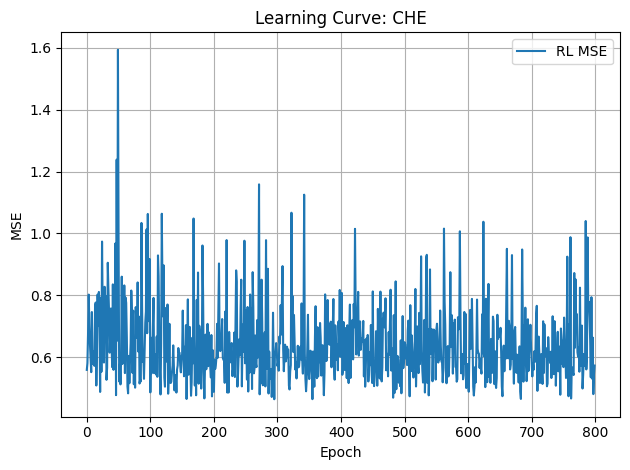

✅ Plot saved to results/annual/figures/CHE_donors_probabilities.pdf


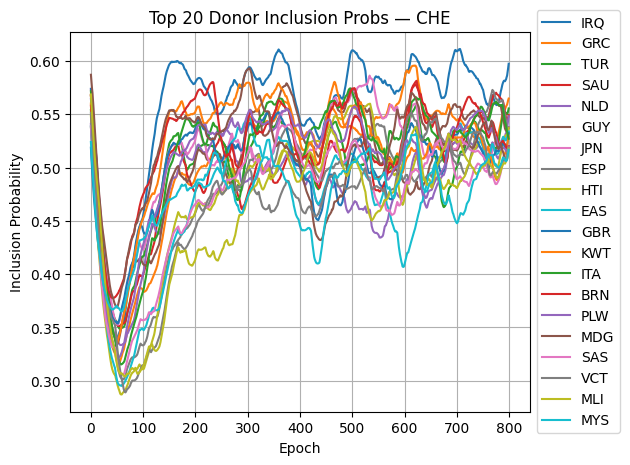

📦 Loaded results_DZA.pkl
✅ Plot saved to results/annual/figures/DZA_learning_curve.pdf


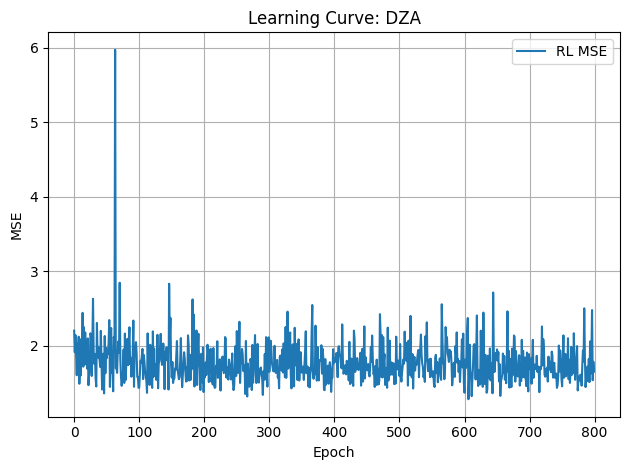

✅ Plot saved to results/annual/figures/DZA_donors_probabilities.pdf


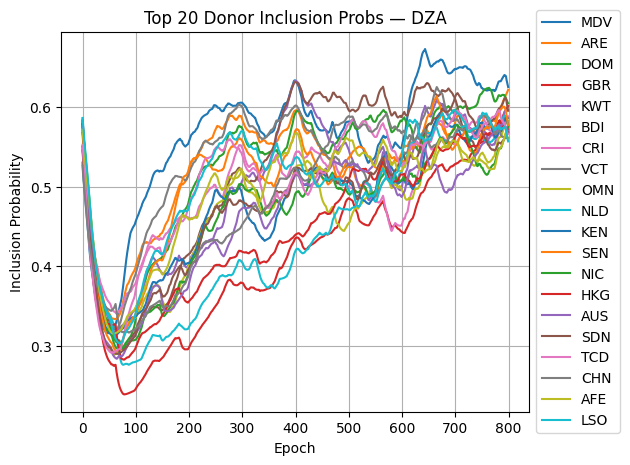

📦 Loaded results_USA.pkl
✅ Plot saved to results/annual/figures/USA_learning_curve.pdf


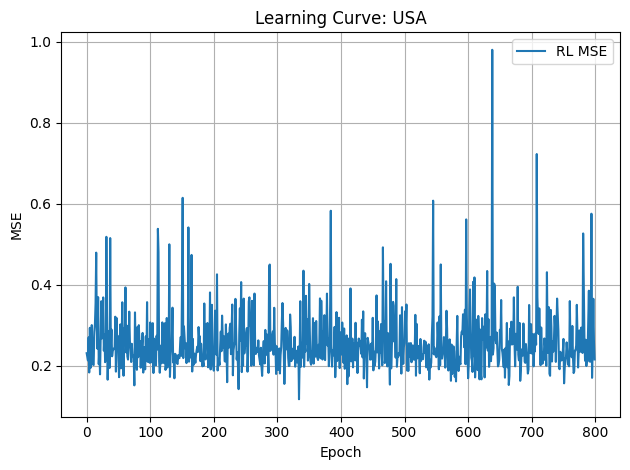

✅ Plot saved to results/annual/figures/USA_donors_probabilities.pdf


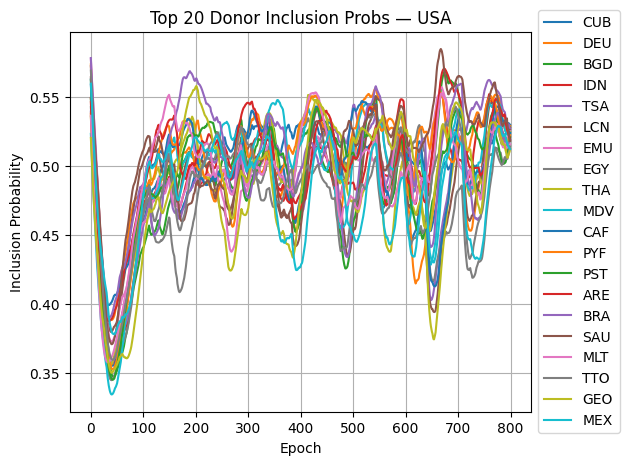

📦 Loaded results_ITA.pkl
✅ Plot saved to results/annual/figures/ITA_learning_curve.pdf


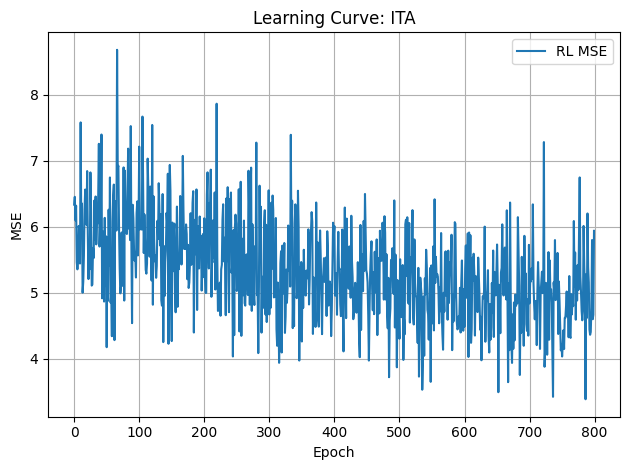

✅ Plot saved to results/annual/figures/ITA_donors_probabilities.pdf


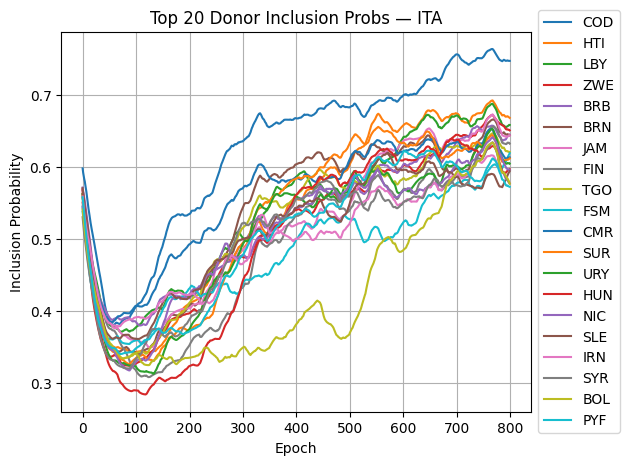

📦 Loaded results_COD.pkl
✅ Plot saved to results/annual/figures/COD_learning_curve.pdf


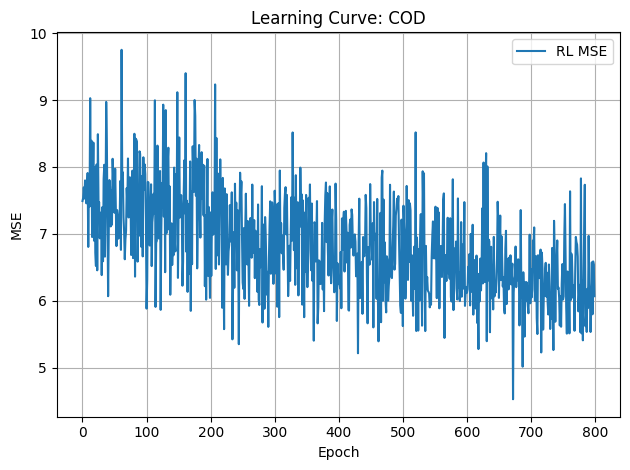

✅ Plot saved to results/annual/figures/COD_donors_probabilities.pdf


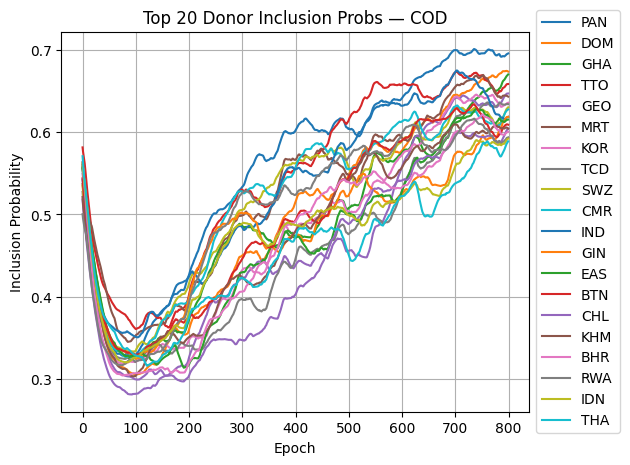

📦 Loaded results_TUR.pkl
✅ Plot saved to results/annual/figures/TUR_learning_curve.pdf


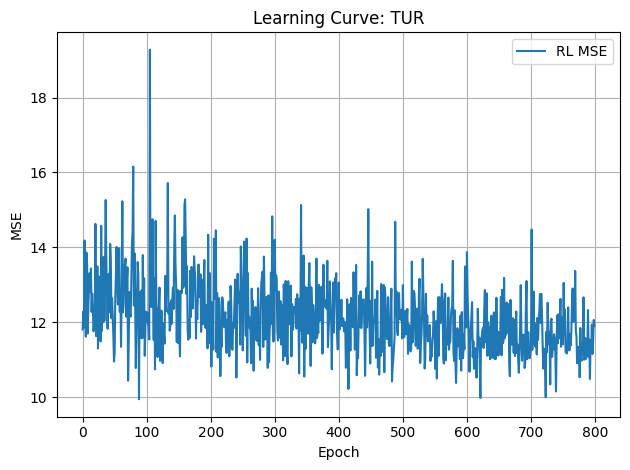

✅ Plot saved to results/annual/figures/TUR_donors_probabilities.pdf


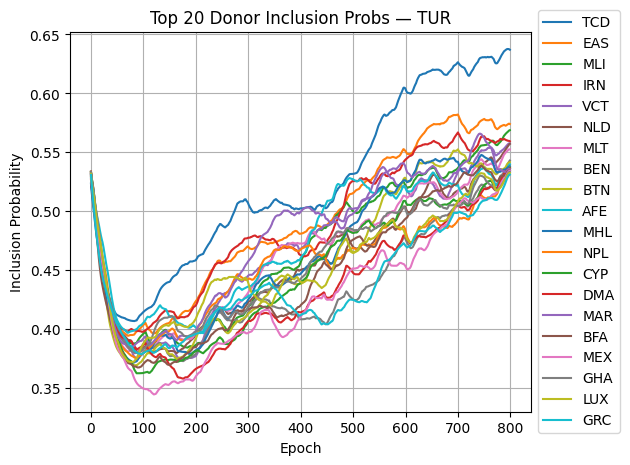

📦 Loaded results_DEU.pkl
✅ Plot saved to results/annual/figures/DEU_learning_curve.pdf


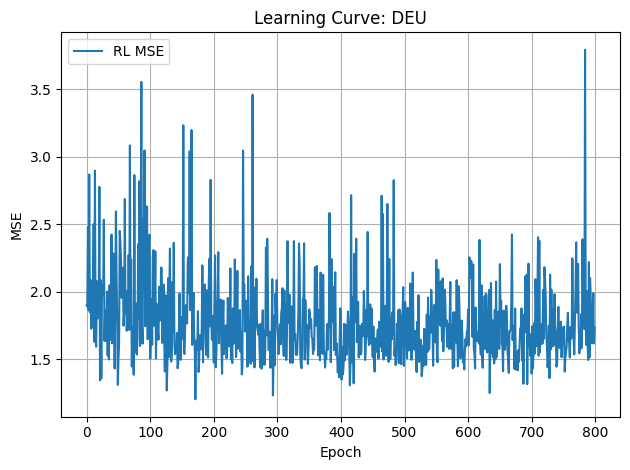

✅ Plot saved to results/annual/figures/DEU_donors_probabilities.pdf


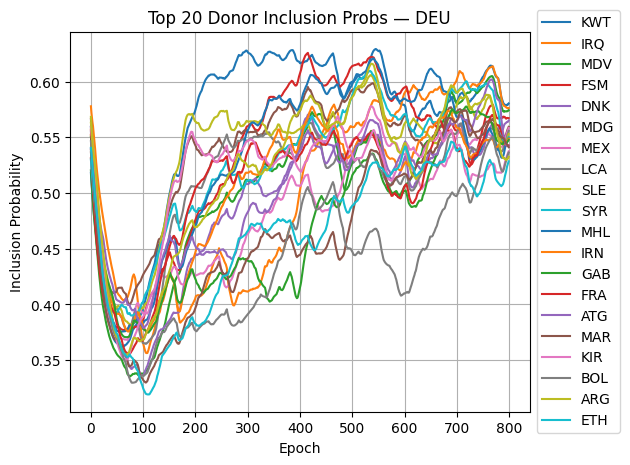

✅ Plot saved to results/annual/figures/summary_plot.pdf


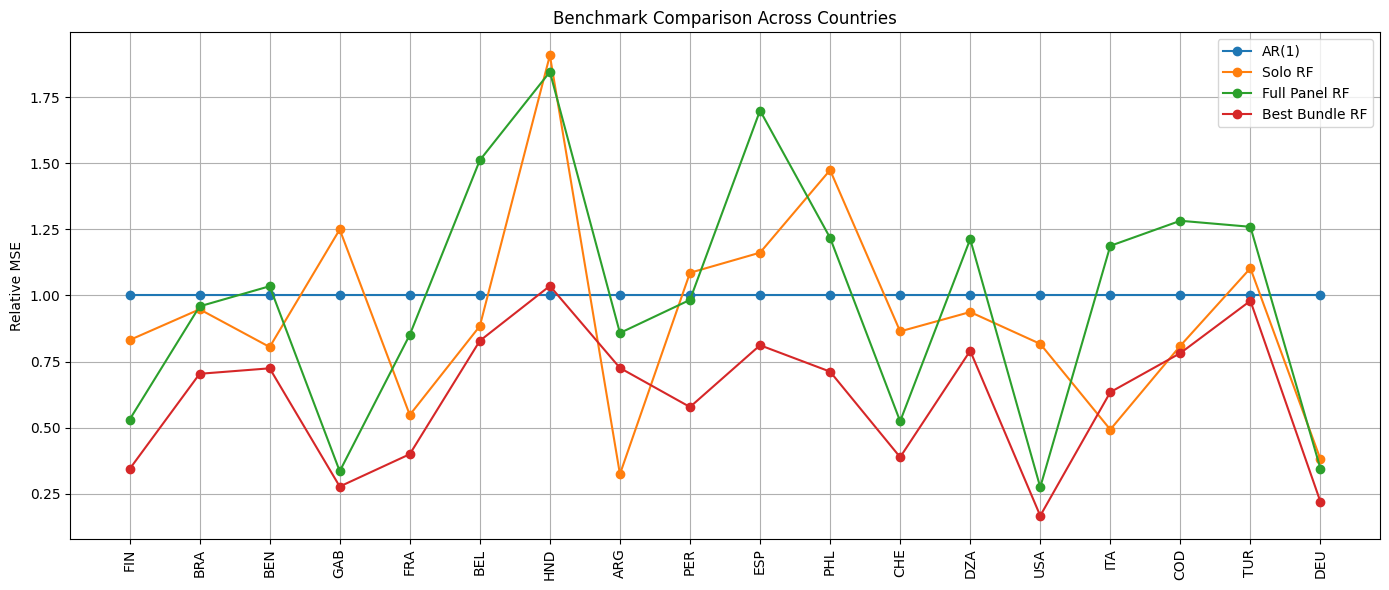

✅ Boxplot saved to results/annual/figures/mse_boxplot.pdf


/tmp/ipykernel_4016372/3271822040.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Method", y="Relative MSE", palette="Set2")


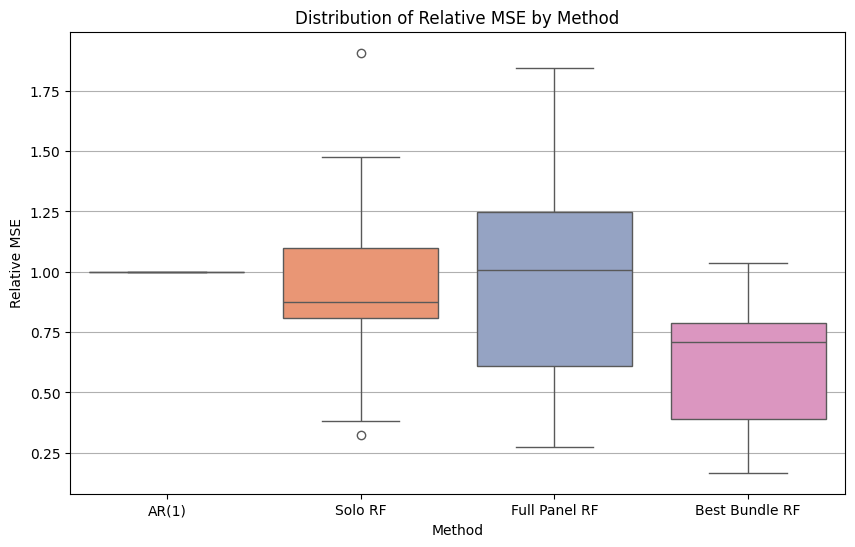

In [4]:
benchmark_df = load_results_and_plot(results_dir="results/annual", top_n_donors=20, save=True, directory="results/annual/figures")
plot_benchmark_summary(benchmark_df, save=True, save_path="results/annual/figures/summary_plot.pdf")
plot_benchmark_boxplot(benchmark_df, save=True, save_path="results/annual/figures/mse_boxplot.pdf")

In [5]:
df_relative = benchmark_df.copy()
for idx, row in df_relative.iterrows():
    ar1_mse = row["AR(1)"]
    if ar1_mse == 0:
        continue  # avoid division by zero
    for col in df_relative.columns:
        if col != "country":
            df_relative.at[idx, col] = row[col] / ar1_mse
    df_relative.at[idx, "AR(1)"] = 1.0  # set AR(1) to baseline

df_relative.sort_values(by="country", inplace=True, ignore_index=True)
df_relative

country  AR(1)   Solo RF  Full Panel RF  Best Bundle RF
0      ARG    1.0  0.324653       0.858332        0.726065
1      BEL    1.0  0.884327       1.511380        0.828753
2      BEN    1.0  0.805248       1.035033        0.724720
3      BRA    1.0  0.947810       0.958989        0.704016
4      CHE    1.0  0.864271       0.524529        0.388800
5      COD    1.0  0.810053       1.282468        0.782148
6      DEU    1.0  0.381005       0.345342        0.220074
7      DZA    1.0  0.937486       1.212931        0.791018
8      ESP    1.0  1.161949       1.699167        0.811974
9      FIN    1.0  0.831507       0.530606        0.343819
10     FRA    1.0  0.548560       0.851429        0.400185
11     GAB    1.0  1.249618       0.335692        0.277876
12     HND    1.0  1.907741       1.845267        1.036160
13     ITA    1.0  0.493182       1.187698        0.634621
14     PER    1.0  1.085841       0.983483        0.578471
15     PHL    1.0  1.474138       1.217893        0.712177
16     TUR    1.0  1.103116       1.259660        0.979834
17     USA    1.0  0.817068       0.275318        0.167384

In [6]:
df_relative.describe().T

count      mean       std       min       25%       50%  \
AR(1)            18.0  1.000000  0.000000  1.000000  1.000000  1.000000   
Solo RF          18.0  0.923754  0.385388  0.324653  0.806449  0.874299   
Full Panel RF    18.0  0.995290  0.461867  0.275318  0.610812  1.009258   
Best Bundle RF   18.0  0.617116  0.258741  0.167384  0.391646  0.708096   

                     75%       max  
AR(1)           1.000000  1.000000  
Solo RF         1.098797  1.907741  
Full Panel RF   1.249219  1.845267  
Best Bundle RF  0.788800  1.036160

In [7]:
results_dir="results/annual"

for filename in os.listdir(results_dir):
    if filename.endswith(".pkl") and filename.startswith("results_"):
        filepath = os.path.join(results_dir, filename)
        with open(filepath, "rb") as f:
            results = pickle.load(f)

        top_bundles = results["top_bundles"]
        target_unit = results["target_unit"]
        top_k = 1
        for rank, (mse, bundle, epoch) in enumerate(top_bundles[:top_k], 1):
            print(f"{rank}. Country: {target_unit}, MSE: {mse:.4f}, Bundle Size: {len(bundle)}, Bundle: {bundle}")

1. Country: FIN, MSE: 3.1578, Bundle Size: 62, Bundle: ['URY', 'HUN', 'JPN', 'PNG', 'LCN', 'ESP', 'ZMB', 'CAN', 'EMU', 'PYF', 'AUS', 'MUS', 'CIV', 'KEN', 'OED', 'BHS', 'SLE', 'GRC', 'KIR', 'COD', 'BRB', 'NOR', 'COL', 'PRT', 'MWI', 'GTM', 'PHL', 'MMR', 'USA', 'DEU', 'MRT', 'MEX', 'NZL', 'GIN', 'BFA', 'ARG', 'COG', 'BRN', 'PAN', 'GNB', 'MHL', 'PER', 'GMB', 'HKG', 'TUN', 'MAR', 'LKA', 'IDN', 'BEN', 'FSM', 'SLV', 'SWZ', 'GUY', 'EAS', 'CYP', 'TCD', 'SYR', 'MLT', 'HTI', 'SDN', 'KWT', 'SGP']
1. Country: BRA, MSE: 6.8897, Bundle Size: 62, Bundle: ['TGO', 'LAC', 'PST', 'PER', 'BOL', 'ATG', 'GMB', 'FIN', 'HIC', 'FRA', 'GIN', 'CAN', 'PHL', 'GTM', 'PAK', 'BLZ', 'BFA', 'SYC', 'URY', 'JOR', 'ITA', 'BGD', 'MEX', 'DEU', 'PRY', 'AUS', 'ESP', 'PYF', 'GRC', 'DNK', 'HUN', 'ZAF', 'BEN', 'ECU', 'ISR', 'PNG', 'EMU', 'OMN', 'WSM', 'MRT', 'IDN', 'ZWE', 'GUY', 'SYR', 'MLT', 'SUR', 'LUX', 'ARE', 'SWZ', 'NER', 'SDN', 'TCD', 'SAU', 'COD', 'ARG', 'BRB', 'BRN', 'QAT', 'KHM', 'BDI', 'KWT', 'IRQ']
1. Country: BEN, MSE